EDA

In [24]:
import kagglehub
path = kagglehub.dataset_download("adityasinghsengar122/analytica-main-problem")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'analytica-main-problem' dataset.
Path to dataset files: /kaggle/input/analytica-main-problem


In [25]:
import os
base_dir = "/kaggle/input/analytica-main-problem"
for root, dirs, files in os.walk(base_dir):
    print(root)

/kaggle/input/analytica-main-problem
/kaggle/input/analytica-main-problem/test
/kaggle/input/analytica-main-problem/test/tumors
/kaggle/input/analytica-main-problem/test/cysts
/kaggle/input/analytica-main-problem/test/normal
/kaggle/input/analytica-main-problem/test/stones
/kaggle/input/analytica-main-problem/train
/kaggle/input/analytica-main-problem/train/tumors
/kaggle/input/analytica-main-problem/train/cysts
/kaggle/input/analytica-main-problem/train/normal
/kaggle/input/analytica-main-problem/train/stones



🔧 Processing category: cysts


100%|██████████| 2528/2528 [00:52<00:00, 47.76it/s]



🔧 Processing category: normal


100%|██████████| 4499/4499 [01:29<00:00, 50.09it/s]



🔧 Processing category: stones


100%|██████████| 3708/3708 [01:05<00:00, 56.33it/s]



🔧 Processing category: tumors


100%|██████████| 2353/2353 [00:43<00:00, 54.59it/s]



✅ Preprocessing completed for /kaggle/input/analytica-main-problem/train → /kaggle/working/processed_data/train

🔧 Processing category: cysts


100%|██████████| 496/496 [00:02<00:00, 189.04it/s]



🔧 Processing category: normal


100%|██████████| 861/861 [00:03<00:00, 243.36it/s]



🔧 Processing category: stones


100%|██████████| 715/715 [00:02<00:00, 240.55it/s]



🔧 Processing category: tumors


100%|██████████| 444/444 [00:01<00:00, 239.60it/s]



✅ Preprocessing completed for /kaggle/input/analytica-main-problem/test → /kaggle/working/processed_data/test

🖼️ Displaying sample preprocessed images...


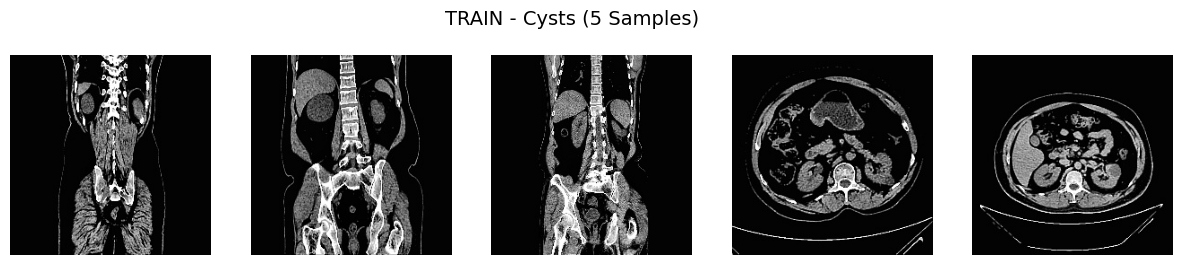

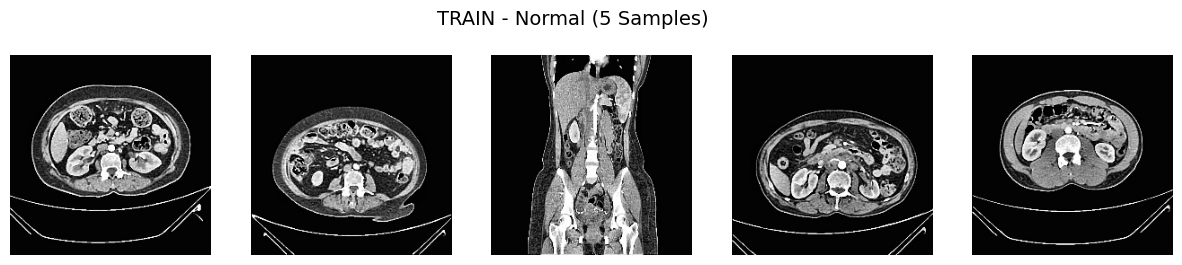

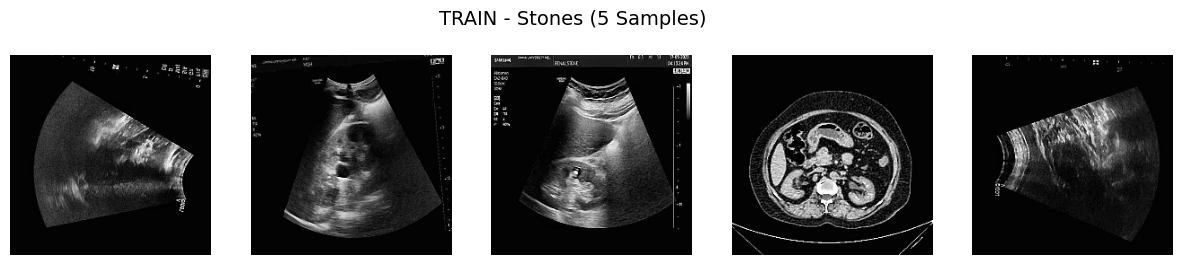

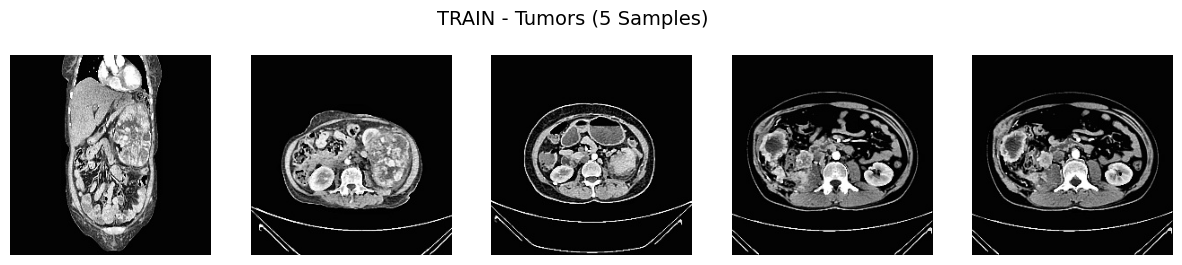

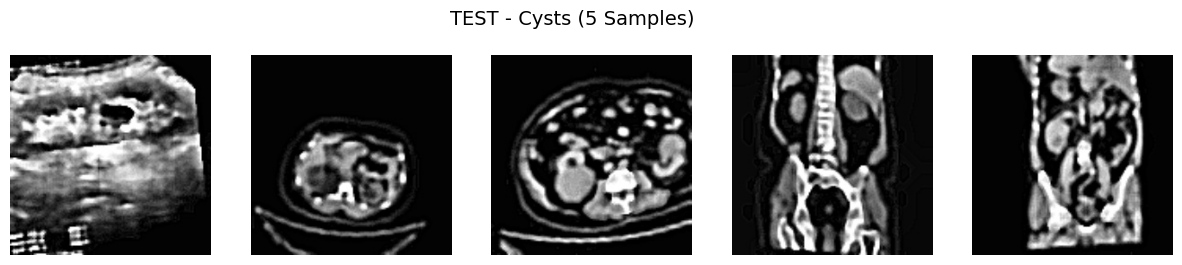

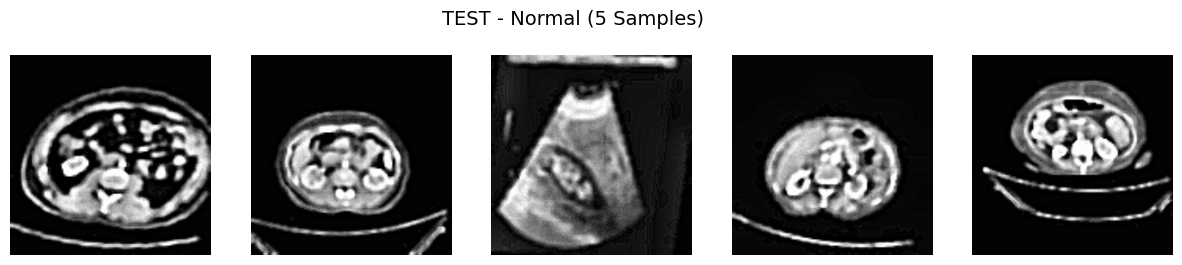

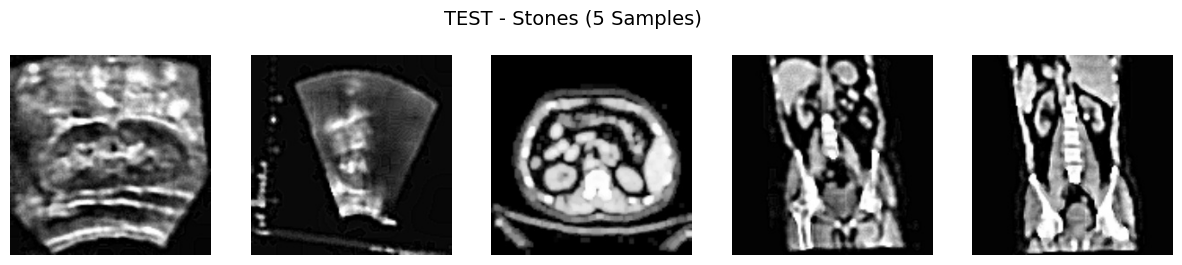

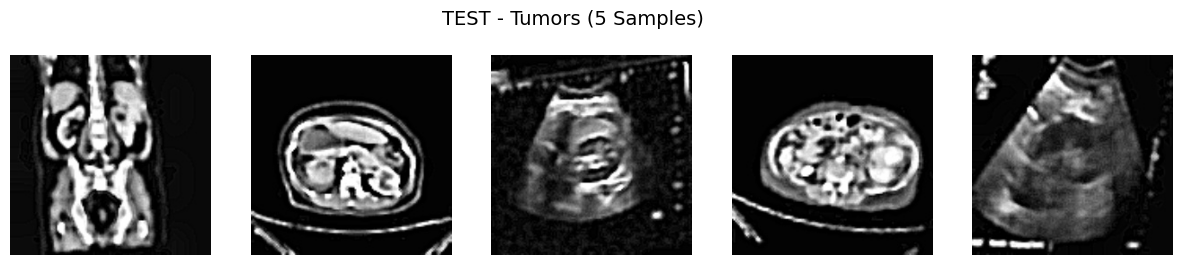

In [51]:
# ✅ IMPORTS
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# ✅ DEFINE INPUT / OUTPUT PATHS
input_train = "/kaggle/input/analytica-main-problem/train"
input_test  = "/kaggle/input/analytica-main-problem/test"

output_train = "/kaggle/working/processed_data/train"
output_test  = "/kaggle/working/processed_data/test"

IMG_SIZE = (224, 224)

# ✅ PREPROCESSING PIPELINES

def preprocess_ultrasound(img):
    """Preprocessing pipeline for ultrasound kidney images."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1️ Remove speckle noise (median + bilateral)
    denoised = cv2.medianBlur(gray, 3)
    denoised = cv2.bilateralFilter(denoised, 5, 75, 75)

    # 2️ Enhance contrast (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)

    # 3️ Sharpen image
    kernel_sharpen = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    sharpened = cv2.filter2D(enhanced, -1, kernel_sharpen)

    # 4️ Resize and normalize
    resized = cv2.resize(sharpened, IMG_SIZE)
    normalized = cv2.normalize(resized, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # 5️ Convert grayscale to 3-channel RGB
    img_rgb = cv2.merge([normalized, normalized, normalized])
    return img_rgb


def preprocess_ct(img):
    """Preprocessing pipeline for CT kidney images."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1️ Light Gaussian smoothing
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # 2️ Histogram equalization for contrast
    equalized = cv2.equalizeHist(blurred)

    # 3️ Sharpen image
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(equalized, -1, kernel_sharpen)

    # 4️ Morphological enhancement (remove small noise)
    morph = cv2.morphologyEx(sharpened, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    # 5️ Resize and normalize
    resized = cv2.resize(morph, IMG_SIZE)
    normalized = cv2.normalize(resized, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # 6️ Convert grayscale to 3-channel RGB
    img_rgb = cv2.merge([normalized, normalized, normalized])
    return img_rgb


# ✅ SIMPLE MODALITY DETECTOR

def detect_modality(img):
    """
    Rough heuristic:
    Ultrasound → darker backgrounds, higher noise variance
    CT → brighter, smoother texture
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    var = np.var(gray)
    mean_intensity = np.mean(gray)

    if var > 500 and mean_intensity < 100:
        return 'ultrasound'
    else:
        return 'ct'


# ✅ FULL DATASET PREPROCESSING FUNCTION

def preprocess_dataset(input_dir, output_dir):
    """
    Applies modality-specific preprocessing to all images in a dataset.
    Folder structure:
        input_dir/
            cysts/
            normal/
            stones/
            tumors/
    """
    os.makedirs(output_dir, exist_ok=True)
    categories = ['cysts', 'normal', 'stones', 'tumors']

    for category in categories:
        src_path = os.path.join(input_dir, category)
        dst_path = os.path.join(output_dir, category)
        os.makedirs(dst_path, exist_ok=True)

        print(f"\n🔧 Processing category: {category}")

        for file in tqdm(os.listdir(src_path)):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(src_path, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Detect modality and apply corresponding preprocessing
                modality = detect_modality(img)
                if modality == 'ultrasound':
                    processed = preprocess_ultrasound(img)
                else:
                    processed = preprocess_ct(img)

                # Convert 0–1 float image → uint8 for saving
                processed_uint8 = (processed * 255).astype(np.uint8)

                save_path = os.path.join(dst_path, file)
                cv2.imwrite(save_path, processed_uint8)

    print(f"\n✅ Preprocessing completed for {input_dir} → {output_dir}")


# ✅ RUN ON BOTH TRAIN AND TEST DATASETS

preprocess_dataset(input_train, output_train)
preprocess_dataset(input_test, output_test)


# ✅ DISPLAY 5 IMAGES PER CATEGORY (TRAIN + TEST)

def show_sample_images(base_dir, title_prefix):
    categories = ['cysts', 'normal', 'stones', 'tumors']

    for category in categories:
        cat_path = os.path.join(base_dir, category)
        all_imgs = [os.path.join(cat_path, img) for img in os.listdir(cat_path)
                    if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

        sample_imgs = random.sample(all_imgs, min(5, len(all_imgs)))

        plt.figure(figsize=(15, 3))
        for i, img_path in enumerate(sample_imgs):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f"{title_prefix} - {category.capitalize()} (5 Samples)", fontsize=14)
        plt.show()


print("\n🖼️ Displaying sample preprocessed images...")
show_sample_images(output_train, "TRAIN")
show_sample_images(output_test, "TEST")
